# Cluster Evaluation and Interpretation

- inputs:
    - ```clustering_results.csv```: complete dataset 
        - original data set (standardized_gtex_data.csv) with features and labels
        - clustering assignments from all clustering models
        - sample IDs
    - ```clustering_labels_only.csv```: clustering summary 
        - sample IDs
        - tissue labels
        - cluster assignments
    - ```clustering_info.json``` : metadata & parameters
        - clustering parameters and results for each clustering model

- evaluates clustering methods (DBSCAN and Spectral) fit to GTEx RNA seq data using several metrics 
    - silhouette score
    - ARI
    - NMI
    - davies-bouldin index

author: @emilyekstrum
<br> 12/1/25

In [40]:
# load in modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

### Load in clustering data from ```cluster_analysis.ipynb```

In [41]:
# load in previous clustering results
results_df = pd.read_csv('clustering_results.csv', index_col=0)

# load the labels for evaluation
labels_df = pd.read_csv('clustering_labels_only.csv')

# load clustering parameters and metrics w/ error handling
try:
    with open('clustering_info.json', 'r') as f:
        clustering_info = json.load(f)
except (FileNotFoundError, json.JSONDecodeError) as e:
    print(f"Error loading clustering_info.json: {e}")
    
    # Extract basic info from the loaded data
    clustering_info = {
        'DBSCAN': {
            'n_clusters': len(set(labels_df['DBSCAN_Labels'])) - (1 if -1 in labels_df['DBSCAN_Labels'].values else 0),
            'n_noise': sum(labels_df['DBSCAN_Labels'] == -1),
            'noise_percentage': (sum(labels_df['DBSCAN_Labels'] == -1) / len(labels_df)) * 100
        },
        'DBSCAN_PCA': {
            'n_clusters': len(set(labels_df['DBSCAN_PCA_Labels'])) - (1 if -1 in labels_df['DBSCAN_PCA_Labels'].values else 0),
            'n_noise': sum(labels_df['DBSCAN_PCA_Labels'] == -1),
            'noise_percentage': (sum(labels_df['DBSCAN_PCA_Labels'] == -1) / len(labels_df)) * 100
        },
        'Spectral_NN': {
            'n_clusters': 10,
            'affinity': 'nearest_neighbors',
            'actual_clusters': len(set(labels_df['Spectral_NN_Labels']))
        },
        'Spectral_RBF': {
            'n_clusters': 10,
            'affinity': 'rbf',
            'actual_clusters': len(set(labels_df['Spectral_RBF_Labels']))
        }
    }

print(f"\nLoaded dataset shapes:")
print(f"- Complete results: {results_df.shape}")
print(f"- Labels only: {labels_df.shape}")
print(f"\nClustering methods: {list(clustering_info.keys())}")


Loaded dataset shapes:
- Complete results: (12385, 5006)
- Labels only: (12385, 6)

Clustering methods: ['DBSCAN', 'DBSCAN_PCA', 'Spectral_NN', 'Spectral_RBF']


# External metric analysis
- ARI
- NMI

In [42]:
def calculate_external_metrics(true_labels, cluster_labels, method_name):
    """calculates ARI and NMI for a clustering method"""
    # remove noise points (-1) for external metric analysis
    mask = cluster_labels != -1
    true_filtered = true_labels[mask]
    cluster_filtered = cluster_labels[mask]
    
    if len(cluster_filtered) == 0:
        return {'ARI': np.nan, 'NMI': np.nan, 'samples_used': 0}
    
    ari = adjusted_rand_score(true_filtered, cluster_filtered)
    nmi = normalized_mutual_info_score(true_filtered, cluster_filtered)
    
    return {
        'ARI': ari,
        'NMI': nmi,
        'samples_used': len(cluster_filtered),
        'noise_excluded': sum(cluster_labels == -1)
    }

# calculate external metrics for all clustering methods
external_results = {}
clustering_columns = ['DBSCAN_Labels', 'DBSCAN_PCA_Labels', 'Spectral_NN_Labels', 'Spectral_RBF_Labels']
method_names = ['DBSCAN', 'DBSCAN_PCA', 'Spectral_NN', 'Spectral_RBF']

print("External Clustering Metric Analysis")

for col, method in zip(clustering_columns, method_names):
    true_labels = labels_df['True_Tissue']
    cluster_labels = labels_df[col]
    
    metrics = calculate_external_metrics(true_labels, cluster_labels, method)
    external_results[method] = metrics
    
    print(f"    {method}:")
    print(f"        ARI: {metrics['ARI']:.4f}")
    print(f"        NMI: {metrics['NMI']:.4f}")
    print(f"        Samples used: {metrics['samples_used']:,} (excluded {metrics['noise_excluded']} noise points)\n")

# comparison dataframe
external_df = pd.DataFrame(external_results).T
print("\nSummary:")
print(external_df.round(4))

External Clustering Metric Analysis
    DBSCAN:
        ARI: 0.0161
        NMI: 0.1473
        Samples used: 10,076 (excluded 2309 noise points)

    DBSCAN_PCA:
        ARI: 0.0067
        NMI: 0.1009
        Samples used: 12,225 (excluded 160 noise points)

    Spectral_NN:
        ARI: 0.6250
        NMI: 0.8201
        Samples used: 12,385 (excluded 0 noise points)

    Spectral_RBF:
        ARI: 0.3929
        NMI: 0.6446
        Samples used: 12,385 (excluded 0 noise points)


Summary:
                 ARI     NMI  samples_used  noise_excluded
DBSCAN        0.0161  0.1473       10076.0          2309.0
DBSCAN_PCA    0.0067  0.1009       12225.0           160.0
Spectral_NN   0.6250  0.8201       12385.0             0.0
Spectral_RBF  0.3929  0.6446       12385.0             0.0


### Summary 
According to ARI and NMI metrics, spectral clustering with nearest neighbors affinity is the best clustering method for grouping samples based on their gene expression for tissue type. Spectral_NN had the highest ARI and NMI (0.6250 and 0.8201), indicating the most similarities with the ground truth tissue labels.

## Internal metric analysis
- silhouette score
- davis-bouldin index

In [43]:
def calculate_internal_metrics(features, cluster_labels, method_name):
    """calculate Silhouette Score and Davies-Bouldin Index"""
    # remove noise points (-1) for internal metric analysis
    mask = cluster_labels != -1
    features_filtered = features[mask]
    cluster_filtered = cluster_labels[mask]
    
    if len(cluster_filtered) == 0 or len(set(cluster_filtered)) < 2:
        return {
            'Silhouette_Score': np.nan,
            'Davies_Bouldin_Index': np.nan,
            'samples_used': len(cluster_filtered),
            'n_clusters_evaluated': len(set(cluster_filtered))
        }
    
    # calculate metrics
    silhouette = silhouette_score(features_filtered, cluster_filtered)
    davies_bouldin = davies_bouldin_score(features_filtered, cluster_filtered)
    
    return {
        'Silhouette_Score': silhouette,
        'Davies_Bouldin_Index': davies_bouldin,
        'samples_used': len(cluster_filtered),
        'n_clusters_evaluated': len(set(cluster_filtered)),
        'noise_excluded': sum(cluster_labels == -1)
    }

# get feature data (select only gene columns)
feature_columns = [col for col in results_df.columns if col not in ['Tissue', 'DBSCAN_Labels', 'DBSCAN_PCA_Labels', 
                                                                    'Spectral_NN_Labels', 'Spectral_RBF_Labels', 'Sample_ID']]
gene_features = results_df[feature_columns].values

# calculate internal metrics for all clustering methods
internal_results = {}

print("Internal Clustering Metric Analysis")

for col, method in zip(clustering_columns, method_names):
    cluster_labels = labels_df[col]
    
    metrics = calculate_internal_metrics(gene_features, cluster_labels, method)
    internal_results[method] = metrics
    
    print(f"    {method}:")
    print(f"        Silhouette Score: {metrics['Silhouette_Score']:.4f}")
    print(f"        Davies-Bouldin Index: {metrics['Davies_Bouldin_Index']:.4f}")
    print(f"        Clusters evaluated: {metrics['n_clusters_evaluated']}")
    print(f"        Samples used: {metrics['samples_used']:,} (excluded {metrics['noise_excluded']} noise points)\n")

# comparison dataframe
internal_df = pd.DataFrame(internal_results).T
print("\nSummary:")
print(internal_df.round(4))

Internal Clustering Metric Analysis
    DBSCAN:
        Silhouette Score: 0.0339
        Davies-Bouldin Index: 1.3710
        Clusters evaluated: 7
        Samples used: 10,076 (excluded 2309 noise points)

    DBSCAN_PCA:
        Silhouette Score: 0.1893
        Davies-Bouldin Index: 1.2674
        Clusters evaluated: 4
        Samples used: 12,225 (excluded 160 noise points)

    Spectral_NN:
        Silhouette Score: 0.1778
        Davies-Bouldin Index: 1.7034
        Clusters evaluated: 10
        Samples used: 12,385 (excluded 0 noise points)

    Spectral_RBF:
        Silhouette Score: 0.1862
        Davies-Bouldin Index: 1.4481
        Clusters evaluated: 10
        Samples used: 12,385 (excluded 0 noise points)


Summary:
              Silhouette_Score  Davies_Bouldin_Index  samples_used  \
DBSCAN                  0.0339                1.3710       10076.0   
DBSCAN_PCA              0.1893                1.2674       12225.0   
Spectral_NN             0.1778                1.70

### Summary 
According to the internal metrics (silhouette score and davis-bouldin index), PCA->DBSCAN was the best performing clustering method. The silhouette score is the highest (0.1893) and the davies-bouldin index was the lowest (1.2674), indicating the most distinct and separable clusters.

### Visualize metrics

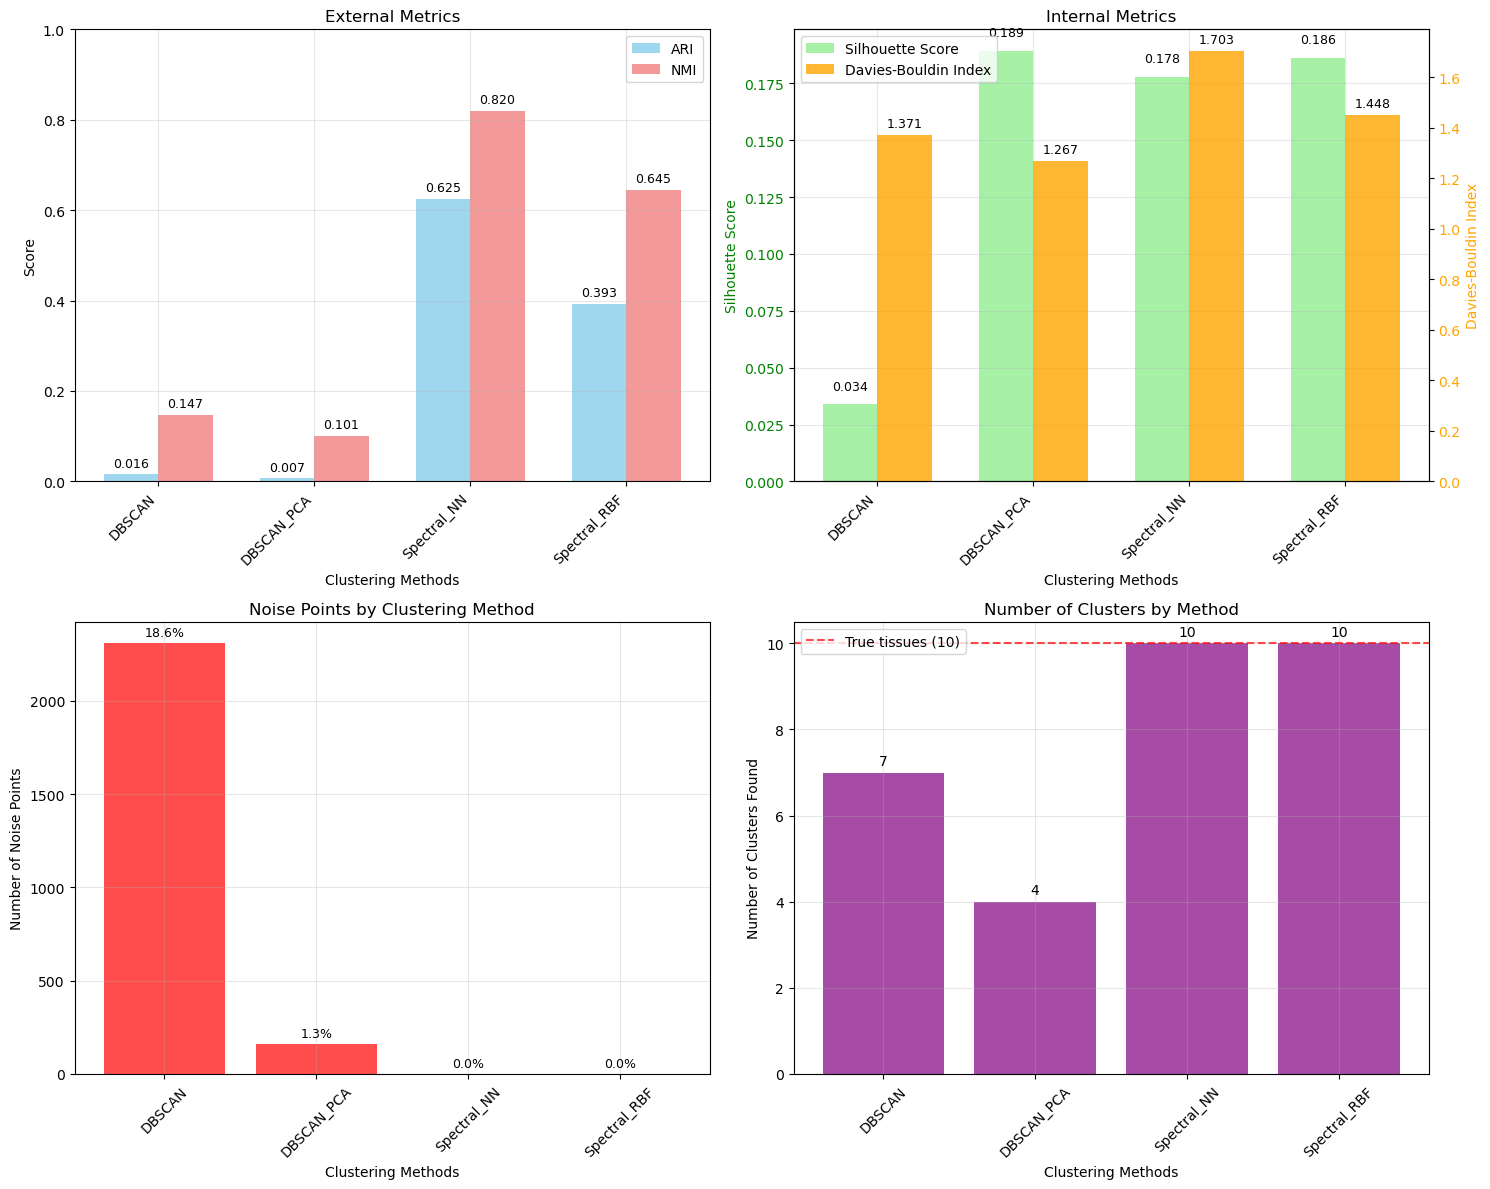

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# external metrics comparision
ax1 = axes[0, 0]
methods = list(external_results.keys())
ari_scores = [external_results[m]['ARI'] for m in methods]
nmi_scores = [external_results[m]['NMI'] for m in methods]

x = np.arange(len(methods))
width = 0.35

ax1.bar(x - width/2, ari_scores, width, label='ARI', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, nmi_scores, width, label='NMI', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Clustering Methods')
ax1.set_ylabel('Score')
ax1.set_title('External Metrics')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# add value labels on bars
for i, (ari, nmi) in enumerate(zip(ari_scores, nmi_scores)):
    ax1.text(i - width/2, ari + 0.01, f'{ari:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i + width/2, nmi + 0.01, f'{nmi:.3f}', ha='center', va='bottom', fontsize=9)

# internal metric comparison
ax2 = axes[0, 1]
sil_scores = [internal_results[m]['Silhouette_Score'] for m in methods]
db_scores = [internal_results[m]['Davies_Bouldin_Index'] for m in methods]

# twin axis for davies bouldin
ax2_twin = ax2.twinx()

bars1 = ax2.bar(x - width/2, sil_scores, width, label='Silhouette Score', alpha=0.8, color='lightgreen')
bars2 = ax2_twin.bar(x + width/2, db_scores, width, label='Davies-Bouldin Index', alpha=0.8, color='orange')

ax2.set_xlabel('Clustering Methods')
ax2.set_ylabel('Silhouette Score', color='green')
ax2_twin.set_ylabel('Davies-Bouldin Index', color='orange')
ax2.set_title('Internal Metrics')
ax2.set_xticks(x)
ax2.set_xticklabels(methods, rotation=45, ha='right')

# legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='y', labelcolor='green')
ax2_twin.tick_params(axis='y', labelcolor='orange')

# value labels
for i, (sil, db) in enumerate(zip(sil_scores, db_scores)):
    ax2.text(i - width/2, sil + 0.005, f'{sil:.3f}', ha='center', va='bottom', fontsize=9)
    ax2_twin.text(i + width/2, db + 0.02, f'{db:.3f}', ha='center', va='bottom', fontsize=9)

#  noise analysis
ax3 = axes[1, 0]
noise_counts = [external_results[m]['noise_excluded'] for m in methods]
noise_percentages = [clustering_info[m].get('noise_percentage', 0) for m in methods]

bars = ax3.bar(methods, noise_counts, alpha=0.7, color='red')
ax3.set_xlabel('Clustering Methods')
ax3.set_ylabel('Number of Noise Points')
ax3.set_title('Noise Points by Clustering Method')
ax3.tick_params(axis='x', rotation=45)

# add percentage labels on bars
for i, (count, pct) in enumerate(zip(noise_counts, noise_percentages)):
    ax3.text(i, count + max(noise_counts)*0.01, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

ax3.grid(True, alpha=0.3)

# number of clusters analysis
ax4 = axes[1, 1]
cluster_counts = []
for method in methods:
    if method in ['DBSCAN', 'DBSCAN_PCA']:
        cluster_counts.append(clustering_info[method]['n_clusters'])
    else:
        cluster_counts.append(clustering_info[method]['actual_clusters'])

bars = ax4.bar(methods, cluster_counts, alpha=0.7, color='purple')
ax4.set_xlabel('Clustering Methods')
ax4.set_ylabel('Number of Clusters Found')
ax4.set_title('Number of Clusters by Method')
ax4.tick_params(axis='x', rotation=45)

# add value labels on bars
for i, count in enumerate(cluster_counts):
    ax4.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)

# add horizontal line for true number of tissues
true_tissues = len(labels_df['True_Tissue'].unique())
ax4.axhline(y=true_tissues, color='red', linestyle='--', alpha=0.7, 
           label=f'True tissues ({true_tissues})')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identifying the most important genes for clustering

### Approach:
 
Analysis using:
1. High variance genes
    - Rationale: The most variant genes are likekly to drive separation between clusters by creating partitions that maximize inter-clustering variance and minimize intra-clustering variance. 
    - Method: Calculate and rank variance for each gene.
    - Limitations: Assumes variable genes contain important information.

2. Cluster-discriminative genes (ANOVA)
    - Rationale: Determines genes that are significantly different between clusters
    - Mehtod: ANOVA f-test to measure inter and intra cluster variance
    - Limitations: Assumes a linear relationship between gene expression patterns and normally distributed expression data

3. Random forest classifier
    - Rationale: Identifies genes that best predict cluster membership
    - Mehtod: train random forest and extract feature importance
    - Limitations: May overfit the data and describe noise rather than feature information.

4. Cluster variance ratio
    - Rationale: Measures clustering efficiency as "good" clusters should have low intra clustering variance and high inter clustering variance
    - Mehtod: calculate the ratio of variance between clusters to variance within clusters
    - Limitations: may be senstive to outliers

### Aggregate analysis:
- minimizes false positives that are analysis method-specfic
    - any biases that exist for a method will likely be diluted by the other methods

In [45]:
def get_high_variance_genes(features, gene_names, top_k=50):
    """ get genes with highest variance across all samples"""
    variances = np.var(features, axis=0)
    top_indices = np.argsort(variances)[::-1][:top_k]
    return [gene_names[i] for i in top_indices], variances[top_indices]

def get_discriminative_genes(features, cluster_labels, gene_names, top_k=50):
    """ ANOVA F-test to find cluster-discriminative genes"""
    mask = cluster_labels != -1
    if len(np.unique(cluster_labels[mask])) < 2:
        return [], []
    
    selector = SelectKBest(f_classif, k=min(top_k, features.shape[1]))
    selector.fit(features[mask], cluster_labels[mask])
    indices = selector.get_support(indices=True)
    scores = selector.scores_[indices]
    sorted_idx = np.argsort(scores)[::-1]
    return [gene_names[indices[i]] for i in sorted_idx], scores[sorted_idx]

def get_random_forest_importance(features, cluster_labels, gene_names, top_k=50):
    """ Random Forest feature importance for clustering genes"""
    mask = cluster_labels != -1
    if len(np.unique(cluster_labels[mask])) < 2:
        return [], []
    
    # subset of features to decrease computational demands
    n_features = min(1000, features.shape[1])
    high_var_indices = np.argsort(np.var(features, axis=0))[::-1][:n_features]
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(features[mask][:, high_var_indices], cluster_labels[mask])
    
    # get feature importances
    importances = rf.feature_importances_
    top_indices = np.argsort(importances)[::-1][:top_k]
    
    return [gene_names[high_var_indices[i]] for i in top_indices], importances[top_indices]

def get_between_within_ratio_genes(features, cluster_labels, gene_names, top_k=50):
    """calculate between-cluster vs within-cluster variance ratio"""
    mask = cluster_labels != -1
    features_clean = features[mask]
    labels_clean = cluster_labels[mask]
    
    if len(np.unique(labels_clean)) < 2:
        return [], []
    
    ratios = []
    for i in range(features_clean.shape[1]):
        gene_values = features_clean[:, i]
        
        # between-cluster variance
        cluster_means = [np.mean(gene_values[labels_clean == c]) for c in np.unique(labels_clean)]
        overall_mean = np.mean(gene_values)
        between_var = np.var(cluster_means)
        
        # within-cluster variance
        within_vars = [np.var(gene_values[labels_clean == c]) for c in np.unique(labels_clean)]
        within_var = np.mean(within_vars)
        
        # ratio (higher = better clustering gene)
        ratio = between_var / (within_var + 1e-8)
        ratios.append(ratio)
    
    top_indices = np.argsort(ratios)[::-1][:top_k]
    return [gene_names[i] for i in top_indices], np.array(ratios)[top_indices]

# select best clustering method based on ARI
best_method = max(external_results.keys(), key=lambda x: external_results[x]['ARI'])
best_clusters = labels_df[clustering_columns[method_names.index(best_method)]]

print(f"Using {best_method} for gene-importance clustering analysis\n")

# high variance genes
var_genes, var_scores = get_high_variance_genes(gene_features, feature_columns)
print("Top 10 highest variance genes:")
for i in range(10):
    print(f"  {i+1:2d}. {var_genes[i][:25]:25s} {var_scores[i]:.4f}")

Using Spectral_NN for gene-importance clustering analysis

Top 10 highest variance genes:
   1. ENSG00000181323.7         1.0000
   2. ENSG00000109511.11        1.0000
   3. ENSG00000189372.4         1.0000
   4. ENSG00000211951.2         1.0000
   5. ENSG00000211923.1         1.0000
   6. ENSG00000110244.6         1.0000
   7. ENSG00000244575.3         1.0000
   8. ENSG00000105428.5         1.0000
   9. ENSG00000203942.4         1.0000
  10. ENSG00000186009.4         1.0000


In [46]:
# discriminative genes (ANOVA)
disc_genes, disc_scores = get_discriminative_genes(gene_features, best_clusters, feature_columns)
if disc_genes:
    print("\nTop 10 cluster-discriminative genes (ANOVA):")
    for i in range(min(10, len(disc_genes))):
        print(f"  {i+1:2d}. {disc_genes[i][:25]:25s} {disc_scores[i]:.2f}")


Top 10 cluster-discriminative genes (ANOVA):
   1. ENSG00000065308.4         19445.67
   2. ENSG00000141837.19        18662.95
   3. ENSG00000167619.11        16232.72
   4. ENSG00000043355.11        15439.16
   5. ENSG00000161992.5         14875.25
   6. ENSG00000161509.13        13262.81
   7. ENSG00000124493.13        13065.98
   8. ENSG00000253230.8         13028.79
   9. ENSG00000152154.10        12696.67
  10. ENSG00000177679.15        12693.31


In [47]:
# random Forest importance
rf_genes, rf_scores = get_random_forest_importance(gene_features, best_clusters, feature_columns)
if rf_genes:
    print("\nTop 10 Random Forest important genes:")
    for i in range(min(10, len(rf_genes))):
        print(f"  {i+1:2d}. {rf_genes[i][:25]:25s} {rf_scores[i]:.4f}")


Top 10 Random Forest important genes:
   1. ENSG00000205517.12        0.0153
   2. ENSG00000149131.15        0.0131
   3. ENSG00000110436.11        0.0129
   4. ENSG00000015592.16        0.0118
   5. ENSG00000138758.11        0.0102
   6. ENSG00000167614.13        0.0101
   7. ENSG00000131471.6         0.0100
   8. ENSG00000176533.12        0.0097
   9. ENSG00000224958.5         0.0093
  10. ENSG00000168280.16        0.0090


In [48]:
# between/within cluster variance ratio
ratio_genes, ratio_scores = get_between_within_ratio_genes(gene_features, best_clusters, feature_columns)
if ratio_genes:
    print("\nTop 10 genes by between/within cluster variance ratio:")
    for i in range(min(10, len(ratio_genes))):
        print(f"  {i+1:2d}. {ratio_genes[i][:25]:25s} {ratio_scores[i]:.2f}")


Top 10 genes by between/within cluster variance ratio:
   1. ENSG00000065308.4         20.40
   2. ENSG00000049449.8         14.94
   3. ENSG00000141837.19        13.43
   4. ENSG00000167619.11        11.96
   5. ENSG00000180921.6         10.97
   6. ENSG00000196361.9         10.85
   7. ENSG00000043355.11        10.78
   8. ENSG00000152154.10        10.66
   9. ENSG00000177679.15        10.58
  10. ENSG00000159166.13        10.43


In [49]:
# find consensus genes across multiple methods
all_methods = {
    'High_Variance': set(var_genes[:30]),
    'ANOVA_Discriminative': set(disc_genes[:30]) if disc_genes else set(),
    'Random_Forest': set(rf_genes[:30]) if rf_genes else set(),
    'Variance_Ratio': set(ratio_genes[:30]) if ratio_genes else set()
}

# count how many methods identify each gene
gene_counts = {}
for method_name, genes in all_methods.items():
    for gene in genes:
        gene_counts[gene] = gene_counts.get(gene, 0) + 1

# sort genes by how many methods identified them
consensus_genes = sorted(gene_counts.items(), key=lambda x: x[1], reverse=True)

print(f"\nGenes identified by multiple methods:")
for gene, count in consensus_genes[:20]:  # Top 20
    methods = [name for name, genes in all_methods.items() if gene in genes]
    print(f"  {gene[:30]:30s} ({count}/4 methods: {', '.join(methods)})")


Genes identified by multiple methods:
  ENSG00000187266.13             (2/4 methods: High_Variance, Random_Forest)
  ENSG00000132698.14             (2/4 methods: ANOVA_Discriminative, Variance_Ratio)
  ENSG00000143847.15             (2/4 methods: ANOVA_Discriminative, Variance_Ratio)
  ENSG00000065308.4              (2/4 methods: ANOVA_Discriminative, Variance_Ratio)
  ENSG00000152154.10             (2/4 methods: ANOVA_Discriminative, Variance_Ratio)
  ENSG00000049449.8              (2/4 methods: ANOVA_Discriminative, Variance_Ratio)
  ENSG00000137699.16             (2/4 methods: ANOVA_Discriminative, Variance_Ratio)
  ENSG00000180921.6              (2/4 methods: ANOVA_Discriminative, Variance_Ratio)
  ENSG00000159166.13             (2/4 methods: ANOVA_Discriminative, Variance_Ratio)
  ENSG00000043355.11             (2/4 methods: ANOVA_Discriminative, Variance_Ratio)
  ENSG00000161509.13             (2/4 methods: ANOVA_Discriminative, Variance_Ratio)
  ENSG00000124493.13             (

In [50]:
# high confidence genes (identified by >=2 methods)
high_confidence = [gene for gene, count in consensus_genes if count >= 2]
print(f"\nHigh confidence clustering genes (2+ methods): {len(high_confidence)}")


High confidence clustering genes (2+ methods): 21


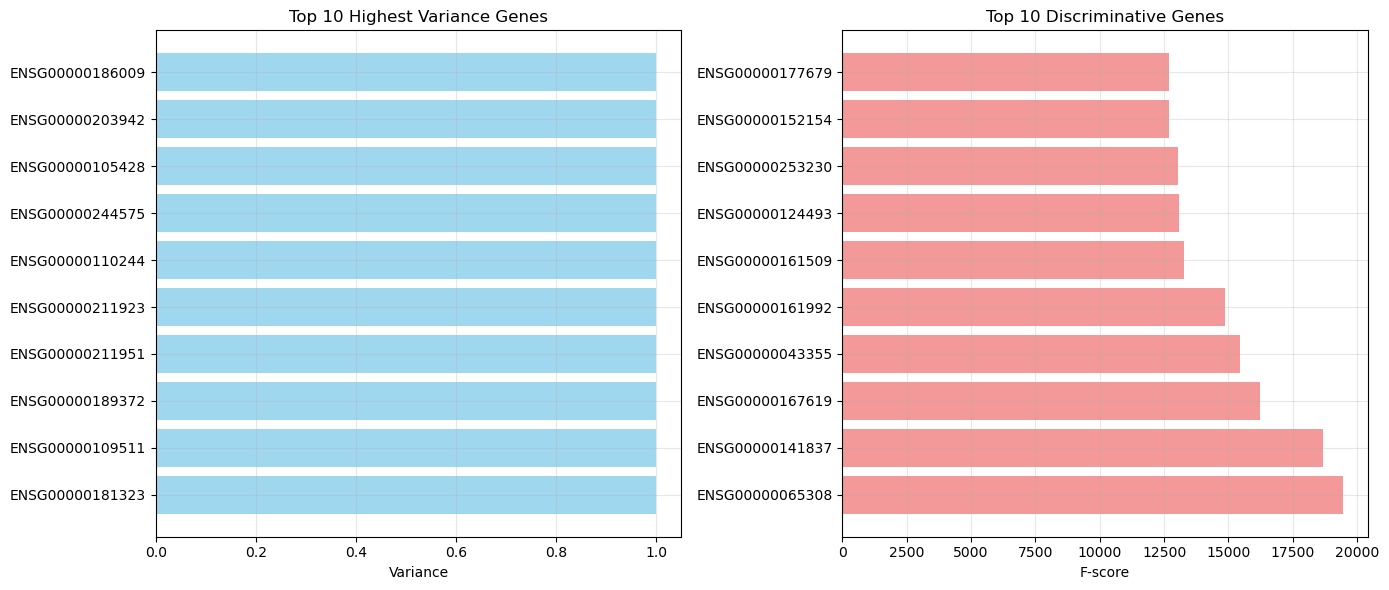

In [51]:
# zisualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# high variance genes
ax1 = axes[0]
top_genes = [name.split('.')[0][:15] for name in var_genes[:10]]
ax1.barh(range(10), var_scores[:10], color='skyblue', alpha=0.8)
ax1.set_yticks(range(10))
ax1.set_yticklabels(top_genes)
ax1.set_xlabel('Variance')
ax1.set_title('Top 10 Highest Variance Genes')
ax1.grid(True, alpha=0.3)

# discriminative genes
ax2 = axes[1]
if disc_genes:
    top_disc_genes = [name.split('.')[0][:15] for name in disc_genes[:10]]
    ax2.barh(range(10), disc_scores[:10], color='lightcoral', alpha=0.8)
    ax2.set_yticks(range(10))
    ax2.set_yticklabels(top_disc_genes)
    ax2.set_xlabel('F-score')
    ax2.set_title('Top 10 Discriminative Genes')
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No discriminative genes', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Discriminative Genes')

plt.tight_layout()
plt.show()

### Findings
1. 21 genes were found to be important for clustering.

2. Across all four analysis methods, important genes were identified by only 2/4 methods. While this multi-method analysis approach was intended to be robust in identifying the most important genes for clustering, it did not identify any genes with perfect consensus across all methods. Thus, the findings of this analysis method should be interpreted with caution.

    - important genes:
        - ENSG00000187266.13             
            - (2/4 methods: High_Variance, Random_Forest)
            - encodes for erythropoietin recpetor protein - binds EPO hormone during red blood cell production
        - ENSG00000132698.14             
            - (2/4 methods: ANOVA_Discriminative, Variance_Ratio)
            - encodes RAB25 - GTPase protein involved in trafficking - associated with tumor suppression and oncogene activity
        - ENSG00000143847.15             
            - (2/4 methods: ANOVA_Discriminative, Variance_Ratio)
            - encodes liprin-alpha-4 protein - involved in neurotransmitter release at synapses
        - ENSG00000065308.4              
            - (2/4 methods: ANOVA_Discriminative, Variance_Ratio)
            - encodes TraM2 protein - involved in tranlocating proteins at the endoplasmic reticulum - linked to several diseases
        - ENSG00000152154.10             
            - (2/4 methods: ANOVA_Discriminative, Variance_Ratio)
            - encodes transmembrane protein 178A - involved in bone remodeling via calcium signaling

# Identifying the most important genes for each tissue

### Approach: 

Analysis using mean difference of gene expression levels.
- Rationale: Determine the genes that are most characteristic of each tissue type label
- Method: Calculate mean difference of standardized expression levels for each gene.
- Limitations: Assumes genes with high levels of expression contain importance. Also may be senstivie to outliers. Interpretation may not be intutitive due to to use of standardized gene expression values.

In [53]:
def get_tissue_specific_genes(features, tissue_labels, gene_names, top_k=10):
    """find genes with highest differential expression in each tissue using difference in means"""
    tissues = np.unique(tissue_labels)
    tissue_markers = {}
    
    for tissue in tissues:
        tissue_mask = tissue_labels == tissue
        tissue_features = features[tissue_mask]
        other_features = features[~tissue_mask]
        
        # mean expression in this tissue vs others
        tissue_mean = np.mean(tissue_features, axis=0)
        other_mean = np.mean(other_features, axis=0)
        
        # difference in means (tissue vs others) - positive means higher in tissue
        mean_difference = tissue_mean - other_mean
        
        # get top genes by mean difference (highest tissue-specific expression)
        top_indices = np.argsort(mean_difference)[::-1][:top_k]
        
        tissue_markers[tissue] = {
            'genes': [gene_names[i] for i in top_indices],
            'mean_differences': mean_difference[top_indices],
            'tissue_expression': tissue_mean[top_indices],
            'other_expression': other_mean[top_indices]
        }
    
    return tissue_markers

# get tissue-specific markers
tissue_markers = get_tissue_specific_genes(gene_features, labels_df['True_Tissue'], feature_columns)

print("Top 5 tissue-specific genes for each tissue type:\n")
for tissue, data in tissue_markers.items():
    print(f"{tissue}:")
    for i in range(min(5, len(data['genes']))):
        gene_name = data['genes'][i][:25]
        mean_diff = data['mean_differences'][i]
        print(f"  {i+1}. {gene_name:25s} (mean diff: {mean_diff:+.3f})")
    print()

Top 5 tissue-specific genes for each tissue type:

Adipose Tissue:
  1. ENSG00000132170.19        (mean diff: +2.908)
  2. ENSG00000135218.17        (mean diff: +2.891)
  3. ENSG00000161649.12        (mean diff: +2.826)
  4. ENSG00000162618.13        (mean diff: +2.761)
  5. ENSG00000170323.8         (mean diff: +2.757)

Blood:
  1. ENSG00000128340.14        (mean diff: +3.430)
  2. ENSG00000104894.11        (mean diff: +3.378)
  3. ENSG00000136167.13        (mean diff: +3.369)
  4. ENSG00000122122.9         (mean diff: +3.333)
  5. ENSG00000162511.7         (mean diff: +3.314)

Blood Vessel:
  1. ENSG00000163453.11        (mean diff: +2.924)
  2. ENSG00000162458.12        (mean diff: +2.907)
  3. ENSG00000054598.6         (mean diff: +2.834)
  4. ENSG00000187955.11        (mean diff: +2.828)
  5. ENSG00000106624.10        (mean diff: +2.776)

Brain:
  1. ENSG00000169862.18        (mean diff: +2.207)
  2. ENSG00000132692.18        (mean diff: +2.185)
  3. ENSG00000174939.10        (mea

### Findings 
1. Genes in lung tissue have the greatest increase in mean gene expression difference, with gene ENSG00000110195.12 mean difference +4.095.

2. Most important genes per tissue type:
    - Adipose:
        - ENSG00000132170.19        (mean diff: +2.908)
        - encodes PPARG protein primarily found in adipose tissue - regulates adipocyte differentiation
    - Blood:
        - ENSG00000128340.14        (mean diff: +3.430)
        - encodes RAC2 protein in bone marrow & lymphoid tissue - involved in cell movement and immune reponses
    - Blood vessel:
        - ENSG00000163453.11        (mean diff: +2.924)
        - encodes IGFBP7 protein in blood vessels - regulates cell growth
    - Brain:
        - ENSG00000169862.18        (mean diff: +2.207)
        - encodes CTNND2 protein in brain tissue - involved in nerve cell development
    - Colon: 
        - ENSG00000160191.17        (mean diff: +3.243)
        - encodes PDE9A protein in intestinal tissue - regulates cGMP signalling
    - Esophagus:
        - ENSG00000163623.9         (mean diff: +2.275)
        - encodes NKX6-1 protein in esophogeal tissue - involved in mesenchymal cell development
    - Heart:
        - ENSG00000118194.18        (mean diff: +3.544)
        - encodes TNNT2 protein in heart tissue - crucial for heart muscle contraction
    - Lung: 
        - ENSG00000110195.12        (mean diff: +4.095)
        - encodes FOLR1 protein in tracheal tissue - involved in DNA synthesis and repair
    - Muscle:
        - ENSG00000167476.10        (mean diff: +3.835)
        - encodes JSRP1 protein in skeletal muscle tissue - involved in calcium regulation for muscle contractions
    - Skin:
        - ENSG00000181458.10        (mean diff: +2.314)
        - encodes TMEM45A protein in skin tissue - invovled in cell proliferation and migration- linked to cancer progression

# Overall summary:
